In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from time import time
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [111]:
sns.set(font_scale=1.5)

In [112]:
df = pd.read_csv( "resd_clean.csv" )
df.head()

,index,sub_area,n_bhk,surface,price,company_name,township,club_house,school,hospital,mall,park,pool,gym
0,1,bavdhan,1.0,492.0,3.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
1,2,bavdhan,2.0,774.0,6.5,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
2,3,bavdhan,3.0,889.0,7.4,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
3,4,bavdhan,3.0,1018.0,8.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
4,5,mahalunge,2.0,743.0,7.4,godrej properties,godrej hills retreat,yes,yes,yes,yes,yes,yes,yes


In [113]:
df = df.drop(columns=["index", "company_name", "township"]).drop_duplicates()
df.head()

,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym
0,bavdhan,1.0,492.0,3.9,yes,yes,yes,yes,yes,yes,yes
1,bavdhan,2.0,774.0,6.5,yes,yes,yes,yes,yes,yes,yes
2,bavdhan,3.0,889.0,7.4,yes,yes,yes,yes,yes,yes,yes
3,bavdhan,3.0,1018.0,8.9,yes,yes,yes,yes,yes,yes,yes
4,mahalunge,2.0,743.0,7.4,yes,yes,yes,yes,yes,yes,yes


In [114]:
binary_cols = df.iloc[:, 4:].columns.to_list()

laben = LabelEncoder()
for col in binary_cols:
    df[col] = laben.fit_transform(df[col])
    
df.tail(10)


,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym
185,bavdhan,2.0,665.0,6.499,1,0,0,0,1,0,0
186,talegoan,1.0,280.0,1.319,1,0,0,0,1,1,1
187,talegoan,2.0,385.0,1.729,1,0,0,0,1,0,1
188,baner,2.0,730.0,8.700,1,0,0,0,1,1,1
189,baner,3.0,1135.0,12.900,1,0,0,0,1,1,1
190,baner,3.0,1350.0,16.000,1,0,0,0,1,1,1
191,baner,4.0,1600.0,23.000,1,0,0,0,1,1,1
192,baner,2.0,789.0,9.500,0,0,0,0,1,1,1
193,baner,3.0,1107.0,13.500,0,0,0,0,1,1,1
194,baner,2.0,776.0,9.068,1,0,0,0,1,1,1


In [119]:
df_sa_count = df.groupby("sub_area")["price"].count().reset_index()\
                .rename(columns={"price":"count"})\
                .sort_values("count", ascending=False)\
                .reset_index(drop=True)

In [120]:
df_sa_count["sa_contribution"] = df_sa_count["count"]/len(df)

In [121]:


sa_sel_col = df_sa_count.loc[df_sa_count["count"]>7, "sub_area"].to_list()
df["sub_area"] = df["sub_area"].where(df["sub_area"].isin(sa_sel_col), "other")
df["sub_area"].unique(), len(df["sub_area"].unique())
hoten = OneHotEncoder(sparse=False)
X_dummy = hoten.fit_transform( df[["sub_area"]] )
X_dummy.shape, X_dummy, X_dummy.dtype


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((195, 12),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 dtype('float64'))

In [122]:
X_dummy = X_dummy.astype("int64")

In [123]:
sa_cols_name = ["sa"+str(i+1) for i in range(X_dummy.shape[1])]
df.loc[:,sa_cols_name] = X_dummy
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_13548\2821117971.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,sa_cols_name] = X_dummy


,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,...,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
0,bavdhan,1.0,492.0,3.9,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,bavdhan,2.0,774.0,6.5,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,bavdhan,3.0,889.0,7.4,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,bavdhan,3.0,1018.0,8.9,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,mahalunge,2.0,743.0,7.4,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0


In [124]:
df[["sub_area"]+sa_cols_name].drop_duplicates()\
            .sort_values("sub_area").reset_index(drop=True)

,sub_area,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
0,baner,1,0,0,0,0,0,0,0,0,0,0,0
1,bavdhan,0,1,0,0,0,0,0,0,0,0,0,0
2,bt kawade rd,0,0,1,0,0,0,0,0,0,0,0,0
3,hadapsar,0,0,0,1,0,0,0,0,0,0,0,0
4,handewadi,0,0,0,0,1,0,0,0,0,0,0,0
5,hinjewadi,0,0,0,0,0,1,0,0,0,0,0,0
6,kharadi,0,0,0,0,0,0,1,0,0,0,0,0
7,mahalunge,0,0,0,0,0,0,0,1,0,0,0,0
8,nibm,0,0,0,0,0,0,0,0,1,0,0,0
9,other,0,0,0,0,0,0,0,0,0,1,0,0


In [125]:
data = df.select_dtypes(exclude="object")
float_cols = data.select_dtypes( include="float" ).columns.to_list()

In [126]:
corr_cols_list = float_cols+binary_cols

corr_cols_list.remove("price")
corr_cols_list.extend(sa_cols_name)
corr_list = [] # to keep the correlations with price
for col in corr_cols_list:
    corr_list.append( round(data["price"].corr(data[col]),2) )    

corr_list

[0.7,
 0.88,
 0.02,
 -0.04,
 -0.04,
 -0.04,
 0.08,
 0.29,
 0.06,
 0.33,
 -0.11,
 0.08,
 -0.04,
 -0.17,
 0.0,
 -0.11,
 -0.05,
 0.23,
 -0.03,
 -0.0,
 -0.07]

In [127]:
df_corr = pd.DataFrame( data=zip(corr_cols_list, corr_list), 
                 columns=["col_name", "corr"] )\
            .sort_values("corr", ascending=False)\
            .reset_index(drop=True)

In [128]:
features = df_corr.loc[abs(df_corr["corr"])>.1, "col_name"].to_list() 
features, len(features)


(['surface', 'n_bhk', 'sa1', 'pool', 'sa9', 'sa7', 'sa2', 'sa5'], 8)

In [129]:
sa_feature_list = [sa for sa in features if "sa" in sa]
lst = []
for col in sa_feature_list:
    sa_triger = df[col]==1
    sa = df.loc[sa_triger, "sub_area"].to_list()[0]
    x = df.loc[sa_triger, "price"]
    lst.append( (sa, np.mean(x), df[col].sum()) )

lst

[('baner', 16.038999999999998, 12),
 ('nibm', 15.1, 8),
 ('kharadi', 6.6310625000000005, 16),
 ('bavdhan', 5.804400000000001, 10),
 ('handewadi', 4.568818181818182, 11)]

In [130]:



sel_data = data[features+["price"]].copy()
sel_data.head()
sc = StandardScaler(with_std=True, with_mean=True)
sel_data["surface"] = sc.fit_transform(sel_data[["surface"]])
sel_data


,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
0,-1.089917,1.0,0,1,0,0,1,0,3.900
1,-0.331617,2.0,0,1,0,0,1,0,6.500
2,-0.022381,3.0,0,1,0,0,1,0,7.400
3,0.324501,3.0,0,1,0,0,1,0,8.900
4,-0.414976,2.0,0,1,0,0,0,0,7.400
...,...,...,...,...,...,...,...,...,...
190,1.217251,3.0,1,1,0,0,0,0,16.000
191,1.889503,4.0,1,1,0,0,0,0,23.000
192,-0.291282,2.0,1,1,0,0,0,0,9.500
193,0.563823,3.0,1,1,0,0,0,0,13.500


In [131]:
sel_data.to_csv("resd_features.csv", index=False)

## Modeling

In [132]:

data = pd.read_csv("resd_features.csv")
data.shape


(195, 9)

In [133]:
data.describe()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
count,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,1.275333e-16,2.379487,0.061538,0.630769,0.041026,0.082051,0.051282,0.056410,8.669949
std,1.002574e+00,0.846210,0.240934,0.483839,0.198860,0.275149,0.221140,0.231306,5.808464
min,-1.659986e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.319000
25%,-6.112734e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
50%,-2.724585e-01,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,3.957598e-01,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.700000
max,4.167092e+00,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


In [134]:
# sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

In [135]:
data = data.sort_values("surface").reset_index(drop=True)

In [136]:
X = data.iloc[:, :-1]    # Selecting the feature matrix and target vector
y = data["price"]

In [137]:
rs = 118
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=rs) 

In [138]:
'''model_reg= final_model('random',X,y,rs,X_train, X_test, y_train, y_test)
print("Regression Model Executed")'''

'model_reg= final_model(\'random\',X,y,rs,X_train, X_test, y_train, y_test)\nprint("Regression Model Executed")'

In [139]:
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X.values, y.values, test_size=.3, random_state=rs)
        
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_)
    print("Best CV score:", abs(est_cv.best_score_))
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test)
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred), 
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


In [140]:
def plotResidue(estimator, X, y, rs=118):
   

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) 
    
    residue_train = y_train.values.reshape(-1,1)-estimator.predict(X_train.values).reshape(-1,1)
    residue_test = y_test.values.reshape(-1,1)-estimator.predict(X_test.values).reshape(-1,1)                                                     
               
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")

    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

In [141]:
rs=10

mlpReg = MLPRegressor(activation='relu', solver='adam',
                      learning_rate_init=0.001,  max_iter=500,  
                      early_stopping=True, validation_fraction=0.1, 
                      n_iter_no_change=30, tol=1.e-4, random_state=rs)

pg = {"hidden_layer_sizes":[(10,), (20,), (10, 5), (20, 10)], 
      "learning_rate":['constant', 'invscaling', 'adaptive'],
      "alpha":np.logspace(-3,3,5),
      "batch_size":[8,16,32,64]
     }

mlpReg_cv = gridSearchReport( mlpReg, X, y, pg, cv=5, rs=rs )

Best parameters: {'alpha': 1.0, 'batch_size': 8, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant'}
Best CV score: 8.355827866390786
MSE, R2 train: 11.628583584813503 ,  0.6248432971192928
MSE, R2 test: 16.184448570439635 ,  0.5899798358115109
Elapsed time: 188.05 s , 3.13 min


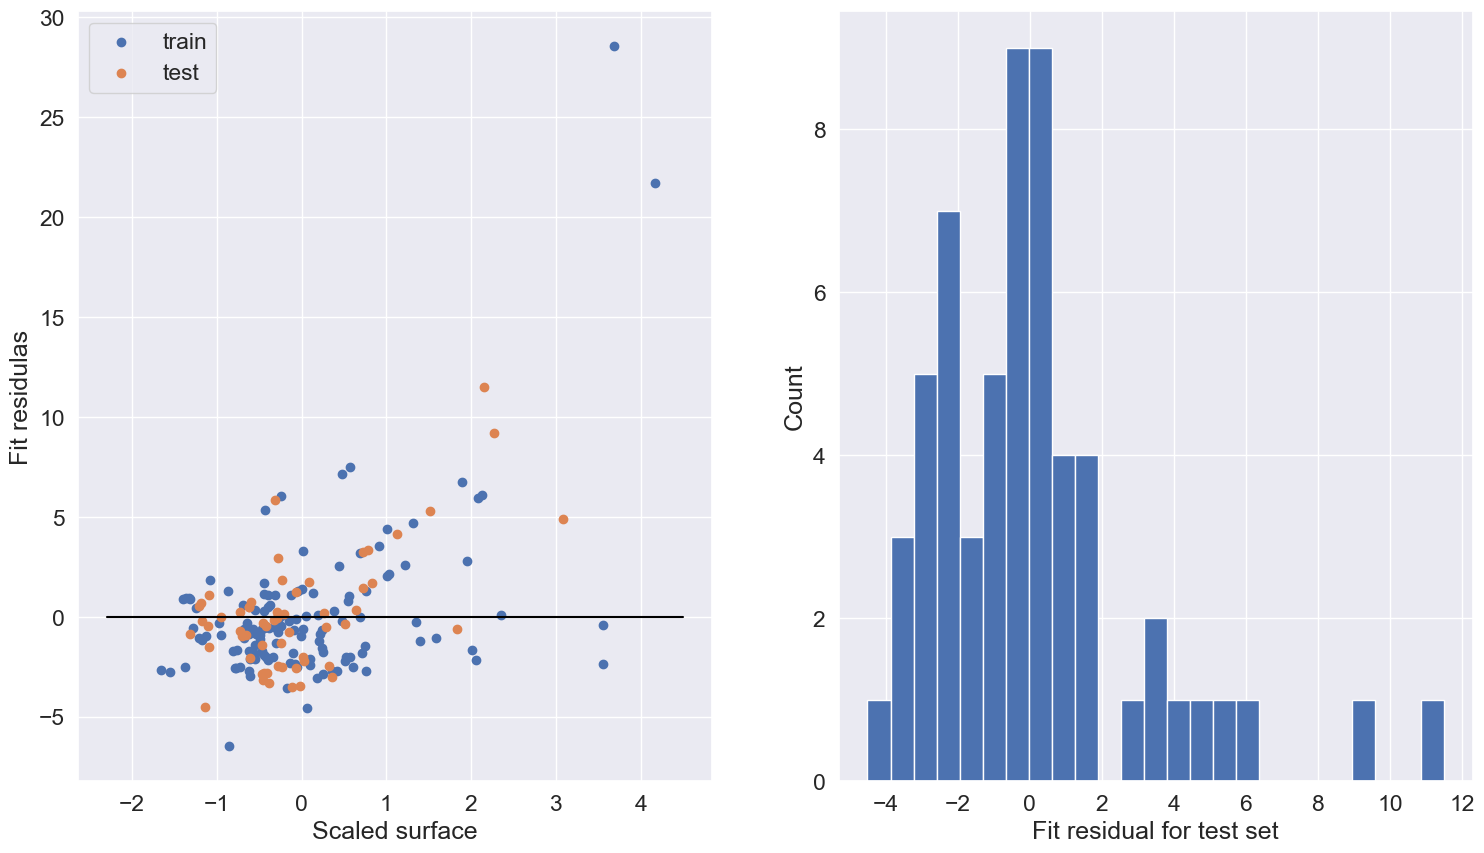

mean residuals: 0.11 
std: 2.95


In [150]:
plotResidue(mlpReg_cv, X, y, rs=rs)

In [151]:
def plot_real_pred(est, X, y, rs):
    """
    Plots the real price vs. predicted price
    Params:
        est: the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X.values, y.values, test_size=.3, random_state=rs)
    
    fig = plt.figure(figsize=(7,7))
    plt.scatter(y_test, est.predict(X_test))
    plt.plot([ min(y_test), max(y_test)], [min(y_test), max(y_test)], c="k")
    plt.xlabel("Real price")
    plt.ylabel("Predicted price")
    plt.show()

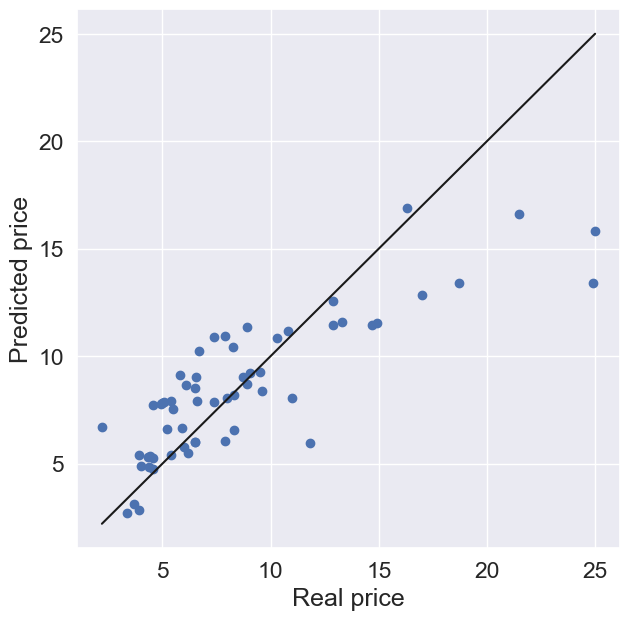

In [152]:
plot_real_pred(mlpReg_cv, X, y, rs)

###  MLP with TensorFlow

In [158]:
# Price min-max normalization to be used with tanh activation
R = np.max(y)-np.min(y)
y0 = np.min(y)
y_scaled = 2*(y-y0)/(R)-1

In [159]:
def y2price(y, R):
    """
    Convert the scaled price to normal price
    Args:
    y: list, serie, array
        scaled price
    R: float
        scale factor
    """
    return y            #R*(y+1)/2.+y0

In [162]:
rs=13
X_train, X_test, y_train, y_test = train_test_split(X.values, y_scaled.values, #train test split
                                                    test_size=.3, 
                                                    random_state=rs)

In [163]:
def tf_template():

    model = tf.keras.models.Sequential()

    # dense hidden layer
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # output layer
    model.add(tf.keras.layers.Dense(1, activation='tanh'))

    return model

In [164]:
# Building a model
tf_model = tf_template()

# Compiling the model
tf_model.compile(loss='mse', 
                 optimizer=tf.keras.optimizers.Adam(), 
                 metrics=['mse', 'mae'])
 
callback=tf.keras.callbacks.EarlyStopping(
                                    monitor="val_loss",
                                    min_delta=1.e-4,
                                    patience=20,
                                    verbose=0,
                                    mode="auto",
                                    baseline=None,
                                    restore_best_weights=True
                                )    

# Training the model
n_epochs = 500
batch_size = 8
tf_model.fit(X_train, y_train, callbacks=[callback],
              epochs=n_epochs, batch_size=batch_size, 
              validation_data=(X_test, y_test),
              verbose=0, shuffle=True)

In [165]:
tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                180       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [166]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(np.arange(len(loss)), loss, label='Training')
    ax[0].plot(np.arange(len(val_loss)), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(len(acc)), acc, label='Training')
    ax[1].plot(np.arange(len(acc)), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')


In [170]:
plot_model_history(tf_model.history)

KeyError: 'loss'

2/2 [==============================] - 0s 2ms/step


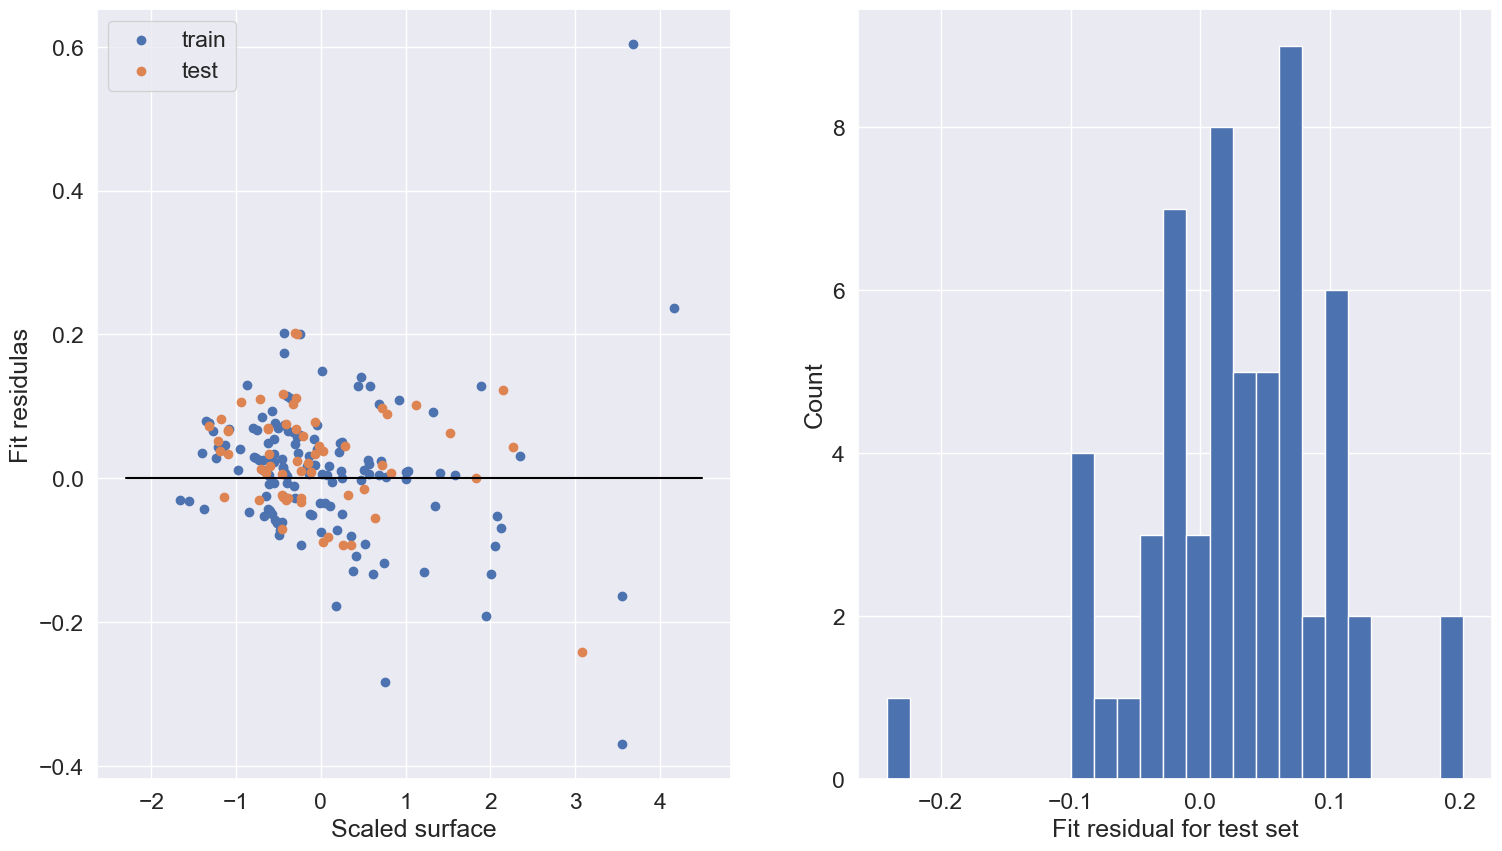

mean residuals: 0.03 
std: 0.07


In [171]:
plotResidue(tf_model, X, y_scaled, rs=rs)

2/2 [==============================] - 0s 2ms/step


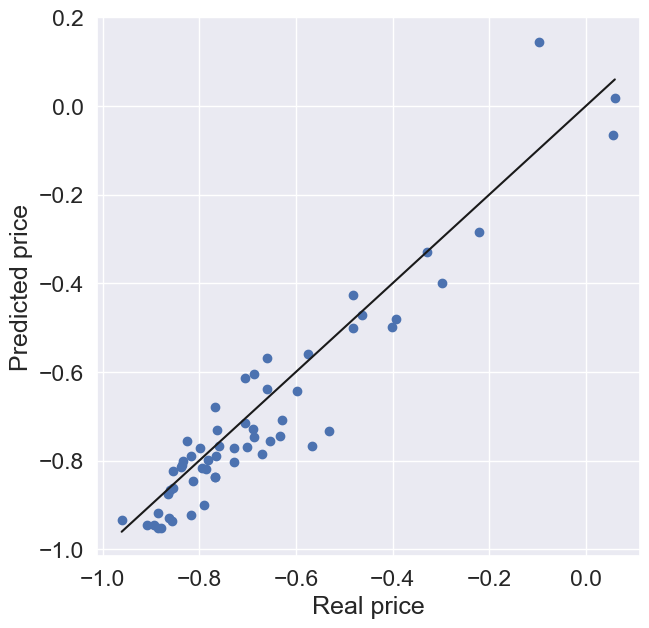

In [172]:
plot_real_pred(tf_model, X, y_scaled, rs)

In [175]:
y_train_pred = tf_model.predict(X_train)
(r2_score( y2price(y_train, R), y2price(y_train_pred, R)), 
mean_squared_error(y2price(y_train, R), y2price(y_train_pred, R)),
mean_absolute_error(y2price(y_train, R), y2price(y_train_pred, R)) )

5/5 [==============================] - 0s 1ms/step


(0.8673456441110038, 0.009861306140403321, 0.06545073077477982)

In [176]:
y_pred = tf_model.predict(X_test)
(r2_score(y2price(y_test, R), y2price(y_pred, R)), 
mean_squared_error(y2price(y_test, R), y2price(y_pred, R)),
mean_absolute_error(y2price(y_test, R), y2price(y_pred, R)) )

2/2 [==============================] - 0s 2ms/step


(0.8801289954463033, 0.006102095812115592, 0.061125016796442264)